### Bandicoot

_bandicoot_ is a Python toolbox to extract behavioral indicators from metadata. It has been created by Yves-Alexandre de Montjoye, Luc Rocher and Alex Pentland at the MIT Media Lab with help from Florent Robic, Kevin Mustelier, Walter Menendez, Zachary Neeley, and Keeley Erhardt.

Documentation: http://bandicoot.mit.edu/docs

<hr>

In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


### Input file

Scheme for ``read_csv``:
> ``interaction,direction,correspondent_id,datetime,call_duration,antenna_id``

Scheme for ``read_orange``:
> ``call_record_type;basic_service;user_msisdn;call_partner_identity;datetime;call_duration;longitude;latitude``

In [2]:
!head -n 5 data/user.csv

interaction,direction,correspondent_id,datetime,call_duration,antenna_id
call,out,d163ffb87507757a4b71c0bd8ae4b0a88b1b13bb,2014-07-01 11:11:27,1440,606
call,out,9b7d7a1ec529cb5252e4b1e50f70cff853e591,2014-07-01 16:42:30,2220,848
call,in,9b7d7a1ec529cb5252e4b1e50f70cff853e591,2014-07-01 17:14:34,2460,897
text,out,ceb8ba95396da4c0163ed774ba89491d3ae40b63,2014-07-01 17:21:16,,902


In [3]:
!head -n 5 data/towers.csv

place_id,longitude,latitude
606,12.4894212,55.7836855
848,12.496692300000001,55.7770971
897,12.505282699999999,55.7722454
902,12.506625999999999,55.7719959


## Loading a user

In [4]:
import bandicoot as bc
U = bc.read_csv('user', 'data/', 'data/towers.csv')

[x] 21 records from 2014-07-01 11:11:27 to 2014-07-20 11:26:27
[x] 5 contacts
[ ] No attributes stored
[x] 17 antennas
[x] Has home
[x] Has texts
[x] Has calls


In [5]:
U.records[:3]

[Record(interaction='call', direction='out', correspondent_id='d163ffb87507757a4b71c0bd8ae4b0a88b1b13bb', datetime=datetime.datetime(2014, 7, 1, 11, 11, 27), call_duration=1440, position=Position(antenna=606)),
 Record(interaction='call', direction='out', correspondent_id='9b7d7a1ec529cb5252e4b1e50f70cff853e591', datetime=datetime.datetime(2014, 7, 1, 16, 42, 30), call_duration=2220, position=Position(antenna=848)),
 Record(interaction='call', direction='in', correspondent_id='9b7d7a1ec529cb5252e4b1e50f70cff853e591', datetime=datetime.datetime(2014, 7, 1, 17, 14, 34), call_duration=2460, position=Position(antenna=897))]

## Individual indicators


1. active_daysmobility point.
2. number_of_contacts
3. number_of_interactions
4. duration_of_calls
5. percent_nocturnal
6. percent_initiated_conversations
7. percent_initiated_interactions
8. response_delay_text
9. response_rate_text
10. entropy_of_contacts
11. balance_of_contacts
12. interactions_per_contact
13. interevent_time

In [6]:
bc.individual.entropy_of_contacts(U, groupby=None)

{'call': 0.9649629230074277, 'text': 2.022808529414703}

In [7]:
bc.individual.percent_initiated_conversations(U, groupby=None)

{'callandtext': 1.0}

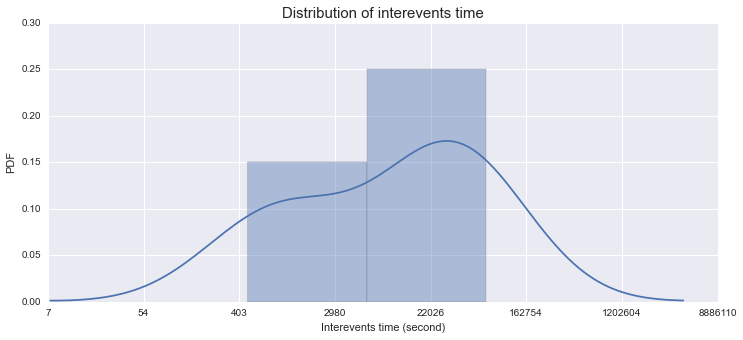

In [8]:
interevent = bc.individual.interevent_time(U, groupby=None, summary=None)

f, axes = plt.subplots(figsize=(12, 5))
sns.distplot(np.log(interevent['call']),  norm_hist=True)
title('Distribution of interevent time', fontsize=15)
plt.xlabel('Interevent time (second)')
plt.ylabel('PDF')
_ = plt.xticks(plt.xticks()[0], [int(np.exp(i)) for i in plt.xticks()[0]])

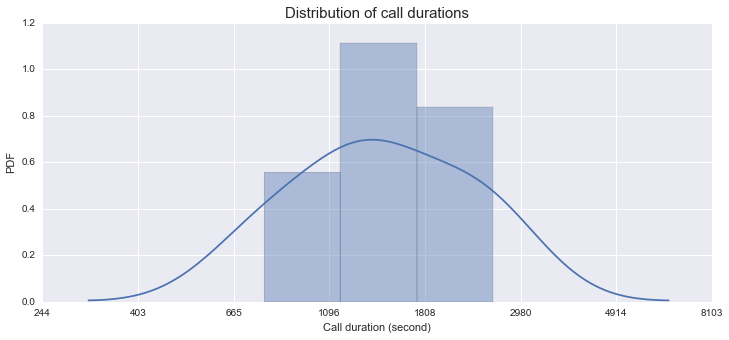

In [9]:
call_durations = bc.individual.call_duration(U, groupby=None, summary=None)

f, ax = plt.subplots(figsize=(12, 5))
sns.distplot(np.log(call_durations['call']), kde=True)
title('Distribution of call durations', fontsize=15)
plt.xlabel('Call duration (second)')
plt.ylabel('PDF')
_ = plt.xticks(plt.xticks()[0], [int(np.exp(i)) for i in plt.xticks()[0]])

## Spatial indicators

1. number_of_antennas
2. entropy_of_antennas
3. percent_at_home
4. radius_of_gyration

In [10]:
print bc.spatial.number_of_antennas(U, groupby=None)

17


In [11]:
bc.spatial.radius_of_gyration(U, groupby=None)

4.789371820200058

In [12]:
print "Home:", U.home
print "Percent at home: {0:.0f}%".format(100 * bc.spatial.percent_at_home(U, groupby=None))

Home: Position(antenna=1552)
Percent at home: 7%


## Weekly aggregation

By default, _bandicoot_ computes the indicators on a weekly basis and returns the mean over all the weeks available and its standard error (sem) in a nested dictionary.

The ``groupby='week'`` or ``groupby=None`` keyword controls the aggregation.

In [13]:
bc.individual.active_days(U, groupby=False)

{'callandtext': {'mean': 1.6666666666666667, 'std': 0.9428090415820634}}

In [14]:
bc.individual.active_days(U)

{'callandtext': {'mean': 1.6666666666666667, 'std': 0.9428090415820634}}

In [15]:
bc.individual.active_days(U, summary=None)

{'callandtext': [3, 1, 1]}

## Summary

Some indicators such as _active_days_ returns one number. Others, such as _duration_of_calls_ returns a distribution.

The summary keyword can take three values:

 - `default`: to return mean and sem;
 - `extended` for the second type of indicators, to return mean, sem, median, skewness and std of the distribution;
 - `None`: to return the full distribution.

In [16]:
bc.individual.call_duration(U, summary='extended', groupby=None)

{'call': {'kurtosis': 1.7013216688170922,
  'max': 2580.0,
  'mean': 1573.3333333333333,
  'median': 1380.0,
  'min': 780.0,
  'skewness': 0.3786440420636483,
  'std': 644.2221838948285}}

In [17]:
print bc.individual.call_duration(U, summary=None, groupby=None)

{'call': [780, 780, 1200, 1320, 1380, 1440, 2220, 2460, 2580]}


## Exporting indicators

In [18]:
bc.utils.all(U, groupby=None)

OrderedDict({'name': 'user',
             'reporting': OrderedDict({'antennas_path': 'data/towers.csv',
             'attributes_path': None,
             'version': '0.2.3',
             'groupby': None,
             'start_time': '2014-07-01 11:11:27',
             'end_time': '2014-07-20 11:26:27',
             'bins': 1,
             'has_call': True,
             'has_text': True,
             'has_home': True,
             'percent_records_missing_location': 0.0,
             'antennas_missing_locations': 0,
             'percent_outofnetwork_calls': 1.0,
             'percent_outofnetwork_texts': 1.0,
             'percent_outofnetwork_contacts': 1.0,
             'percent_outofnetwork_call_durations': 1.0,
             'number_of_records': 21,
             'ignored_records': {'all': 0, 'interaction': 0, 'correspondent_id': 0, 'call_duration': 0, 'direction': 0, 'datetime': 0}}),
             'active_days': {'callandtext': 5},
             'number_of_contacts': {'text': 8, 'call

In [19]:
bc.io.to_csv([bc.utils.all(U, groupby=None)], 'demo_export_user.csv')
bc.io.to_json([bc.utils.all(U, groupby=None)], 'demo_export_user.json')

Successfully exported 1 object(s) to demo_export_user.csv
Successfully exported 1 object(s) to demo_export_user.json


In [20]:
!head -n 5 demo_export_user.csv